---
layout: default
title: "Deep Learning - CNN - Object detection"
categories: deeplearning
permalink: /ML37/
order: 37
comments: true
---

In [3]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from plot_ann import ann
plt.rcParams["mathtext.fontset"] = "cm"
import pandas as pd
import cv2
from scipy.signal import convolve2d, correlate2d
import sklearn
from mpl_flow import Flow
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import proj3d

Populating the interactive namespace from numpy and matplotlib


# Object detection
Object detection is one of the area that has improved more in the last few years. The first step towards object detection is **object localization**.

## Object localization
Image classification is the problem of predicting the class of an object shown in a picture. A task of image classification with localization produces a predicted label for the image and also finds the exact location of the labeled object within the image. Finding the location of an object means defining a **bounding box** that contains the recognized object. Finally an object detection task detects multiple objects (even of different classes) in an image and all their locations.

To train a network on an object localization task we can build on the image classification architectures that we have seen so far. Suppose we have a network for an image classification task that needs to distinguish 3 classes: flower, leaf, background (none of the two). We would have input images, fed into a CNN with some convolutional layers and some final fully connected layers that terminates with a softmax regression layer with 3 hidden units. In order to train a network to localize the classified object we need 4 additional output units: $b_x$, $b_y$, $b_h$, $b_w$.  

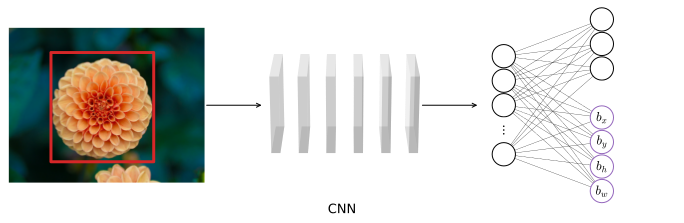

In [92]:
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[0, 2])

ax1.imshow(sklearn.datasets.load_sample_images().images[1][:, 50:-50, :])

x, y, z = np.indices((1,16,1))
l1 = (x >= 0) & (y == 0) & (z >= 0)
l2 = (x >= 0) & (y == 3) & (z >= 0)
l3 = (x >= 0) & (y == 6) & (z >= 0)
l4 = (x >= 0) & (y == 9) & (z >= 0)
l5 = (x >= 0) & (y == 12) & (z >= 0)
l6 = (x >= 0) & (y == 15) & (z >= 0)

ax2.voxels(l1 | l2 | l3 | l4 | l5 | l6, edgecolor='none', facecolors='w', alpha=.3)
ax2.set_box_aspect([1, 2, 1])
ax2.view_init(elev=20, azim=0)
ax2.text2D(0.5, 0, 'CNN', fontsize=13, transform=ax2.transAxes, ha='center', va='top')

ann([ 5, 8], ax=ax3, radius=1.9, node_labels=[*[*'   ', '$\\vdots$', *'     ', '$b_x$', '$b_y$', '$b_h$', '$b_w$']], 
    node_colors=list('kkkwkkkkw')+['C4']*4, edge_colors=list('kkkwkkkk'*3+'w'*8+'kkkwkkkk'), node_fontsize=13)
ax3.set_aspect('equal')

ax1.annotate(' ', (0, 0), (0.47, 0.47), textcoords=ax1.transAxes, bbox=dict(boxstyle='square', pad=5, fc='none', edgecolor='C3', linewidth=3))
ax2.annotate('', (0.1, 0.5), (1, 0.5), xycoords=ax2.transAxes, textcoords=ax1.transAxes, arrowprops=dict(arrowstyle='->'))
ax2.annotate('', (0, 0.5), (0.9, 0.5), xycoords=ax3.transAxes, textcoords=ax2.transAxes, arrowprops=dict(arrowstyle='->'))

for ax in [ax1, ax2, ax3]:
    ax.set_axis_off()